In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane.qchem import excitations
import matplotlib.pyplot as plt
import os

In [3]:
def generate_water_geometry(angle_deg, bond_length=0.9584):
    """Generate coordinates for water with given angle in degrees."""
    angle_rad = np.deg2rad(angle_deg)
    x = bond_length * np.sin(angle_rad / 2)
    z = bond_length * np.cos(angle_rad / 2)
    
    coordinates = np.array([
        [0.0, 0.0, 0.0],    # Oxygen
        [x, 0.0, z],        # Hydrogen 1
        [-x, 0.0, z]        # Hydrogen 2
    ])
    return coordinates

In [4]:
def run_vqe(angle_deg, max_iterations=10, stepsize=0.4):
    coords = generate_water_geometry(angle_deg)
    symbols = ["O", "H", "H"]
    
    hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coords)
    electrons = 10
    hf = qchem.hf_state(electrons, qubits)
    dev = qml.device("default.qubit", wires=qubits)
    
    singles, doubles = excitations(electrons, qubits)
    
    def ansatz(params_s, params_d):
        qml.BasisState(hf, wires=range(qubits))
        for i, ex in enumerate(singles):
            qml.SingleExcitation(params_s[i], wires=ex)
        for i, ex in enumerate(doubles):
            qml.DoubleExcitation(params_d[i], wires=ex)

    @qml.qnode(dev)
    def cost_fn(params_s, params_d):
        ansatz(params_s, params_d)
        return qml.expval(hamiltonian)

    opt = qml.AdamOptimizer(stepsize=stepsize)
    theta_s = np.zeros(len(singles), requires_grad=True)
    theta_d = np.zeros(len(doubles), requires_grad=True)

    for _ in range(max_iterations):
        (theta_s, theta_d), _ = opt.step_and_cost(cost_fn, theta_s, theta_d)

    final_energy = cost_fn(theta_s, theta_d)
    return final_energy

Running VQE for angle 102.0°
Running VQE for angle 102.6°
Running VQE for angle 103.1°
Running VQE for angle 103.7°
Running VQE for angle 104.3°
Running VQE for angle 104.9°
Running VQE for angle 105.4°
Running VQE for angle 106.0°


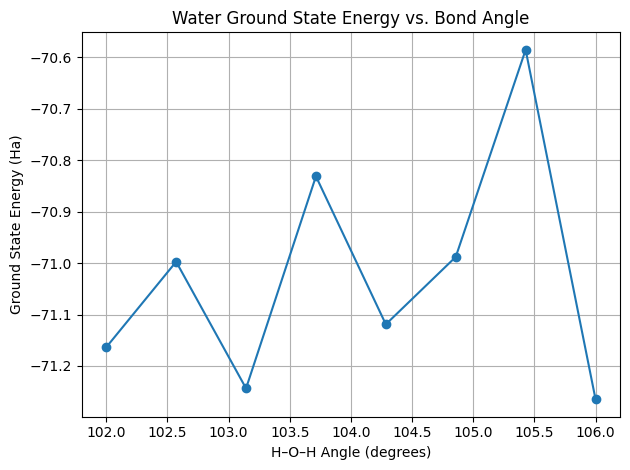

Minimum energy: -71.264693 Ha
Optimal angle: 106.00°


In [ ]:
angles = np.linspace(103.5, 105.5, 11)
energies = []

for angle in angles:
    print(f"Running VQE for angle {angle:.1f}°")
    energy = run_vqe(angle)
    energies.append(energy)

plt.plot(angles, energies, marker='o')
plt.xlabel('H–O–H Angle (degrees)')
plt.ylabel('Ground State Energy (Ha)')
plt.title('Water Ground State Energy vs. Bond Angle')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/Water_Angle_Scan.png')
plt.show()

min_energy = min(energies)
opt_angle = angles[np.argmin(energies)]

print(f"Minimum energy: {min_energy:.6f} Ha")
print(f"Optimal angle: {opt_angle:.2f}°")